# Deep-Learning-Volatility

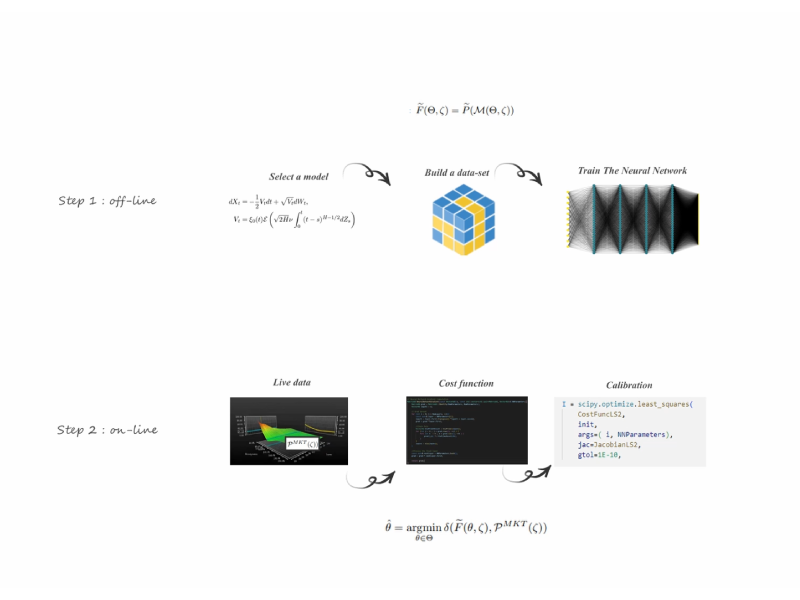

The aim is to utilize the original article, place the learning phase into a time lapse, and accelerate the speed with C++

## Contents

- [Explore Data](#explore-data)  
- [Build the Neural Net](#build-the-neural-net)  
- [Hardcoded the Neural Net and Gradient with C++](#hardcoded-the-neural-net-and-gradient-with-c++)
- [Learning the Rough Bergomi Model in a Time Lapse](#learning-the-rough-bergomi-model-in-a-time-lapse)
- [Calibration](#calibration)

## Simulating a live situation
- [Taking a sample outside the train-test](#taking-a-sample-outside-the-train-test)                                   
- [Doing the entire process and checking the Error](#doing-the-entire-process-and-checking-the-error)


## Author

Dumont Axel

## Initial Paper
[Link to Initial Paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3322085)

## Visualize data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import matplotlib.ticker as mtick
import time
import datetime
import os



f = gzip.GzipFile('TrainrBergomiTermStructure.txt.gz', "r")
dat=np.load(f)
print(dat.shape)
xx=dat[:,:11]
yy=dat[:,11:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])



def sanitize_filename(name):
    invalid_chars = ['/', '\\', ':', '*', '?', '<', '>', '|', '[', ']', '\n', ' ']
    for char in invalid_chars:
        name = name.replace(char, '_')
    return name


#Volatility surface of  yy 
def data_surface (sample_index0 ,sample_index1 ) : 
    now = datetime.time()

    folder_name = now.strftime("%Y%m%d_%H%M%S")

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i in range(sample_index0, sample_index1): 
        vol_data = yy[i]
        params = xx[i]  

        vol_matrix = vol_data.reshape(len(maturities), len(strikes))
        strike_grid, maturity_grid = np.meshgrid(strikes, maturities)

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(strike_grid, maturity_grid, vol_matrix, cmap='viridis')
        
        ax.set_xlabel('Strike')
        ax.set_ylabel('Maturity')
        ax.set_zlabel('Volatility')
        ax.set_title(f'Volatility Surface for Sample {i}\nParameters: {params}')
        fig.colorbar(surface, shrink=0.5, aspect=5)

        plt.savefig(f"{folder_name}/vol_surface_{i}.png")
        plt.close(fig)  
    
    return sample_index1 - sample_index0


def data_surface2 (t, x ) :
    #Data surface after the split of data 
    now = datetime.time()

    folder_name = now.strftime("%Y%m%d_%H%M%Siou")

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i in range(t,x): 
        vol_data = y_test[i]
        params = X_test[i]  
        vol_matrix = vol_data.reshape(len(maturities), len(strikes))
        strike_grid, maturity_grid = np.meshgrid(strikes, maturities)

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(strike_grid, maturity_grid, vol_matrix, cmap='viridis')
        ax.set_xlabel('Strike')
        ax.set_ylabel('Maturity')
        ax.set_zlabel('Volatility')
        ax.set_title(f'Volatility Surface for Sample {i}\nParameters: {params} et {indices_test[i]} yy')
        fig.colorbar(surface, shrink=0.5, aspect=5)
        filename = sanitize_filename(f"{folder_name}/{params}.png")


        plt.savefig(filename)    
    return x



(80000, 99)
(80000, 11)


# -Scale and Normalize data

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

indices = np.arange(xx.shape[0])
original_indexi = 1614
indeex_test_train = 44519
max_seed = 8000
indices = np.arange(xx.shape[0])


X_train, X_test, y_train, y_test , indices_train, indices_test = train_test_split(
    xx, yy,indices, test_size=0.25, random_state=20, ) 



scale = StandardScaler()
scale2=  StandardScaler()

y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)

x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

print(len(indices))

80000


In [3]:
def xtransform(y_train,y_test):
    return [scale.transform(y_train),scale.transform(y_test)]

    
[y_train_transform,y_test_transform]=xtransform(y_train,y_test)

def xinversetransform(y):
    return scale.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=[0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,0,0.5]
lb=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,-1,0.025]
def myscale(x):
    res=np.zeros(11)
    for i in range(11):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(11)
    for i in range(11):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res


x_train_transform = np.array([myscale(x) for x in X_train])
x_test_transform = np.array([myscale(x) for x in X_test])

## - Explore Data

In [4]:

#Play with data 
#finding and see corresponding sample over X_train, X_test, y_train, y_test , indices_train, indices_test
original_indexi = 1614

indices_test_found = np.where(indices_test == original_indexi)
indices_train_found = np.where(indices_train == original_indexi)

print(indices_test_found, indices_train_found)

print(original_indexi, len(indices_test), len(indices_train))

search_values = np.array([0.0874266, 0.113923, 0.0813577, 0.119689, 0.157552, 0.0695512, 0.146975, 0.0661179, 2.85968, -0.00353918, 0.138854])
tolerance = 1e-1
indices_search = np.where(np.all(X_test == search_values, axis=1))[0]
X_test_search_results = X_test[indices_search]

print("Indices corresponding in X_test:", indices_search)
print("Corresponding rows in X_test:")
print(X_test_search_results)


(array([3989], dtype=int64),) (array([], dtype=int64),)
1614 20000 60000
Indices corresponding in X_test: [3989]
Corresponding rows in X_test:
[[ 0.0874266   0.113923    0.0813577   0.119689    0.157552    0.0695512
   0.146975    0.0661179   2.85968    -0.00353918  0.138854  ]]


1614
42965


3990

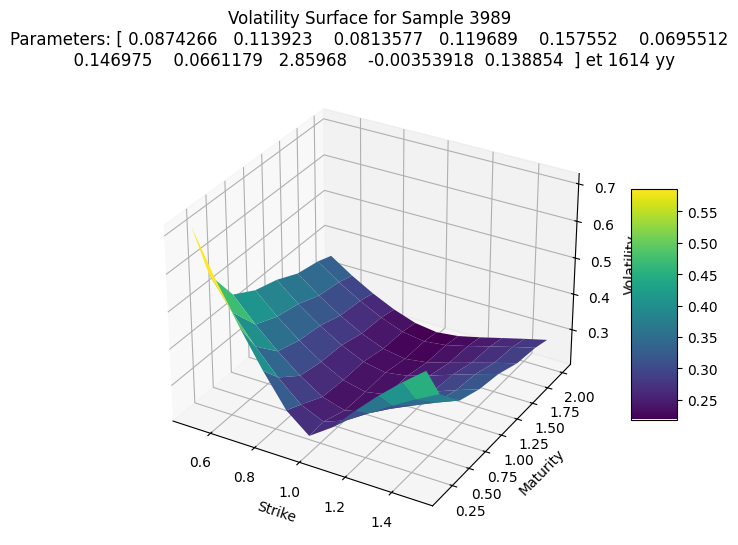

In [5]:

#Play with data 
#finding and see corresponding sample over X_train, X_test, y_train, y_test , indices_train, indices_test

indeex_test_train = 3989

try:
    print(indices_test[indeex_test_train])
except IndexError:
    print("The index is out of bounds for indices_test.")

try:
    print(indices_train[indeex_test_train])
except IndexError:
    print("The index is out of bounds for indices_train.")


data_surface2(3989, 3990) 

#data_surface(1613 , 1615)


## - Build The Neural Net

In [6]:
import keras
from keras.layers import Activation
from keras import backend as K

keras.backend.set_floatx('float64')
input1 = keras.layers.Input(shape=(11,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 
x4=keras.layers.Dense(30,activation = 'elu')(x3)
x5=keras.layers.Dense(88,activation = 'linear')(x4)
modelGEN = keras.models.Model(inputs=input1, outputs=x5)
modelGEN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 30)                360       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 88)                2728      
                                                                 
Total params: 5878 (45.92 KB)
Trainable params: 5878 (45.92 K

In [ ]:
import os
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Settings optimized for timelapse
patience = 100
Epochs = 310
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1,
                          patience=patience)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

checkpoint_dir = "models1/" 
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = ModelCheckpoint(checkpoint_dir + 'model_{epoch}.h5', save_weights_only=True)

modelGEN.compile(loss=root_mean_squared_error, optimizer=keras.optimizers.Adam(lr=0.001))
modelGEN.fit(x_train_transform, y_train_transform, batch_size=16, validation_data=(x_test_transform, y_test_transform), epochs=Epochs, verbose=True,callbacks=[checkpoint])


In [ ]:
#Extracting the last Epoch parameters 
last_epoch = 301  
filename = f'model_{last_epoch}.h5'
filepath = os.path.join(checkpoint_dir, filename)

modelGEN.load_weights(filepath)

NNParameters = []
for i in range(1, len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())



## - Hardcoded the Neural Net and Gradient with C++


In [15]:
import cppNeuralNet as cppNeuralNet

#import C++ code and writing the cost func 

NumLayers=4
NumParameters=11

cppNeuralNet = cppNeuralNet.NeuralNetworkFunctions()

def CostFunc2(x,sample_ind , NNParameters):
    return np.sum(np.power(( cppNeuralNet.NeuralNetwork(x, NNParameters) -y_test_transform[sample_ind]),2))

def Jacobian2(x,sample_ind,  NNParameters):
    return 2*np.sum(( cppNeuralNet.NeuralNetwork(x, NNParameters)-y_test_transform[sample_ind])*cppNeuralNet.NeuralNetworkGradient(x, NNParameters),axis=1)


def CostFuncLS2(x,sample_ind , NNParameters):
    return (cppNeuralNet.NeuralNetwork(x, NNParameters)-y_test_transform[sample_ind])

def JacobianLS2(x,sample_ind , NNParameters):
    return cppNeuralNet.NeuralNetworkGradient(x, NNParameters).T




## - Calibration

In [16]:
import numpy as np
import scipy.optimize
import time

def calculate_rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


CalibratedParameters = []
Timing = []
solutions = np.zeros([4, 11])
times = np.zeros(4)
init = np.zeros(11)

i =   3989

I = scipy.optimize.least_squares( 
    CostFuncLS2,
    init,
    args=( i, NNParameters),
    jac=JacobianLS2,
    gtol=1E-10,)


print(myinverse(I.x)) 
print(xx[1614] ) 
rmse_value = calculate_rmse(myinverse(I.x), xx[1614])
print("RMSE:", rmse_value)


[0.08754491 0.11303441 0.08353313 0.11657137 0.16184415 0.0673167
 0.14953513 0.06059532 2.85581296 0.01202369 0.14086255]
[ 0.0874266   0.113923    0.0813577   0.119689    0.157552    0.0695512
  0.146975    0.0661179   2.85968    -0.00353918  0.138854  ]
RMSE: 0.005534319136392769


In [ ]:

#Calculate average calibration time

import time
import scipy
CalibratedParameters=[]
Timing=[]
solutions=np.zeros([4,11])
times=np.zeros(4)
init=np.zeros(11)
for i in range(5000):
    disp=str(i+1)+"/5000"
    print (disp,end="\r")
    #L-BFGS-B
    start = time.perf_counter()
    I = scipy.optimize.minimize(
    CostFunc2, 
    x0=init, 
    args=( i, NNParameters), 
    method='L-BFGS-B', 
    jac=Jacobian2,  
    tol=1E-10,
    options={"maxiter": 5000}
    )
    end = time.perf_counter()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start = time.perf_counter()
    I=scipy.optimize.minimize(CostFunc2,x0=init,args=(i, NNParameters),method='SLSQP',jac=Jacobian2,tol=1E-10,options={"maxiter":5000})
    end = time.perf_counter()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start = time.perf_counter()
    I=scipy.optimize.minimize(CostFunc2,x0=init,args=(i, NNParameters),method='BFGS',jac=Jacobian2,tol=1E-10,options={"maxiter":5000})
    end = time.perf_counter()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start = time.perf_counter()
    I=scipy.optimize.least_squares(CostFuncLS2,init, JacobianLS2,args=(i,NNParameters),gtol=1E-10)
    end = time.perf_counter()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    
    CalibratedParameters.append(np.copy(solutions))
    Timing.append(np.copy(times))


Improved_speed  = np.mean(Timing,axis=0)*1000
print(Improved_speed )

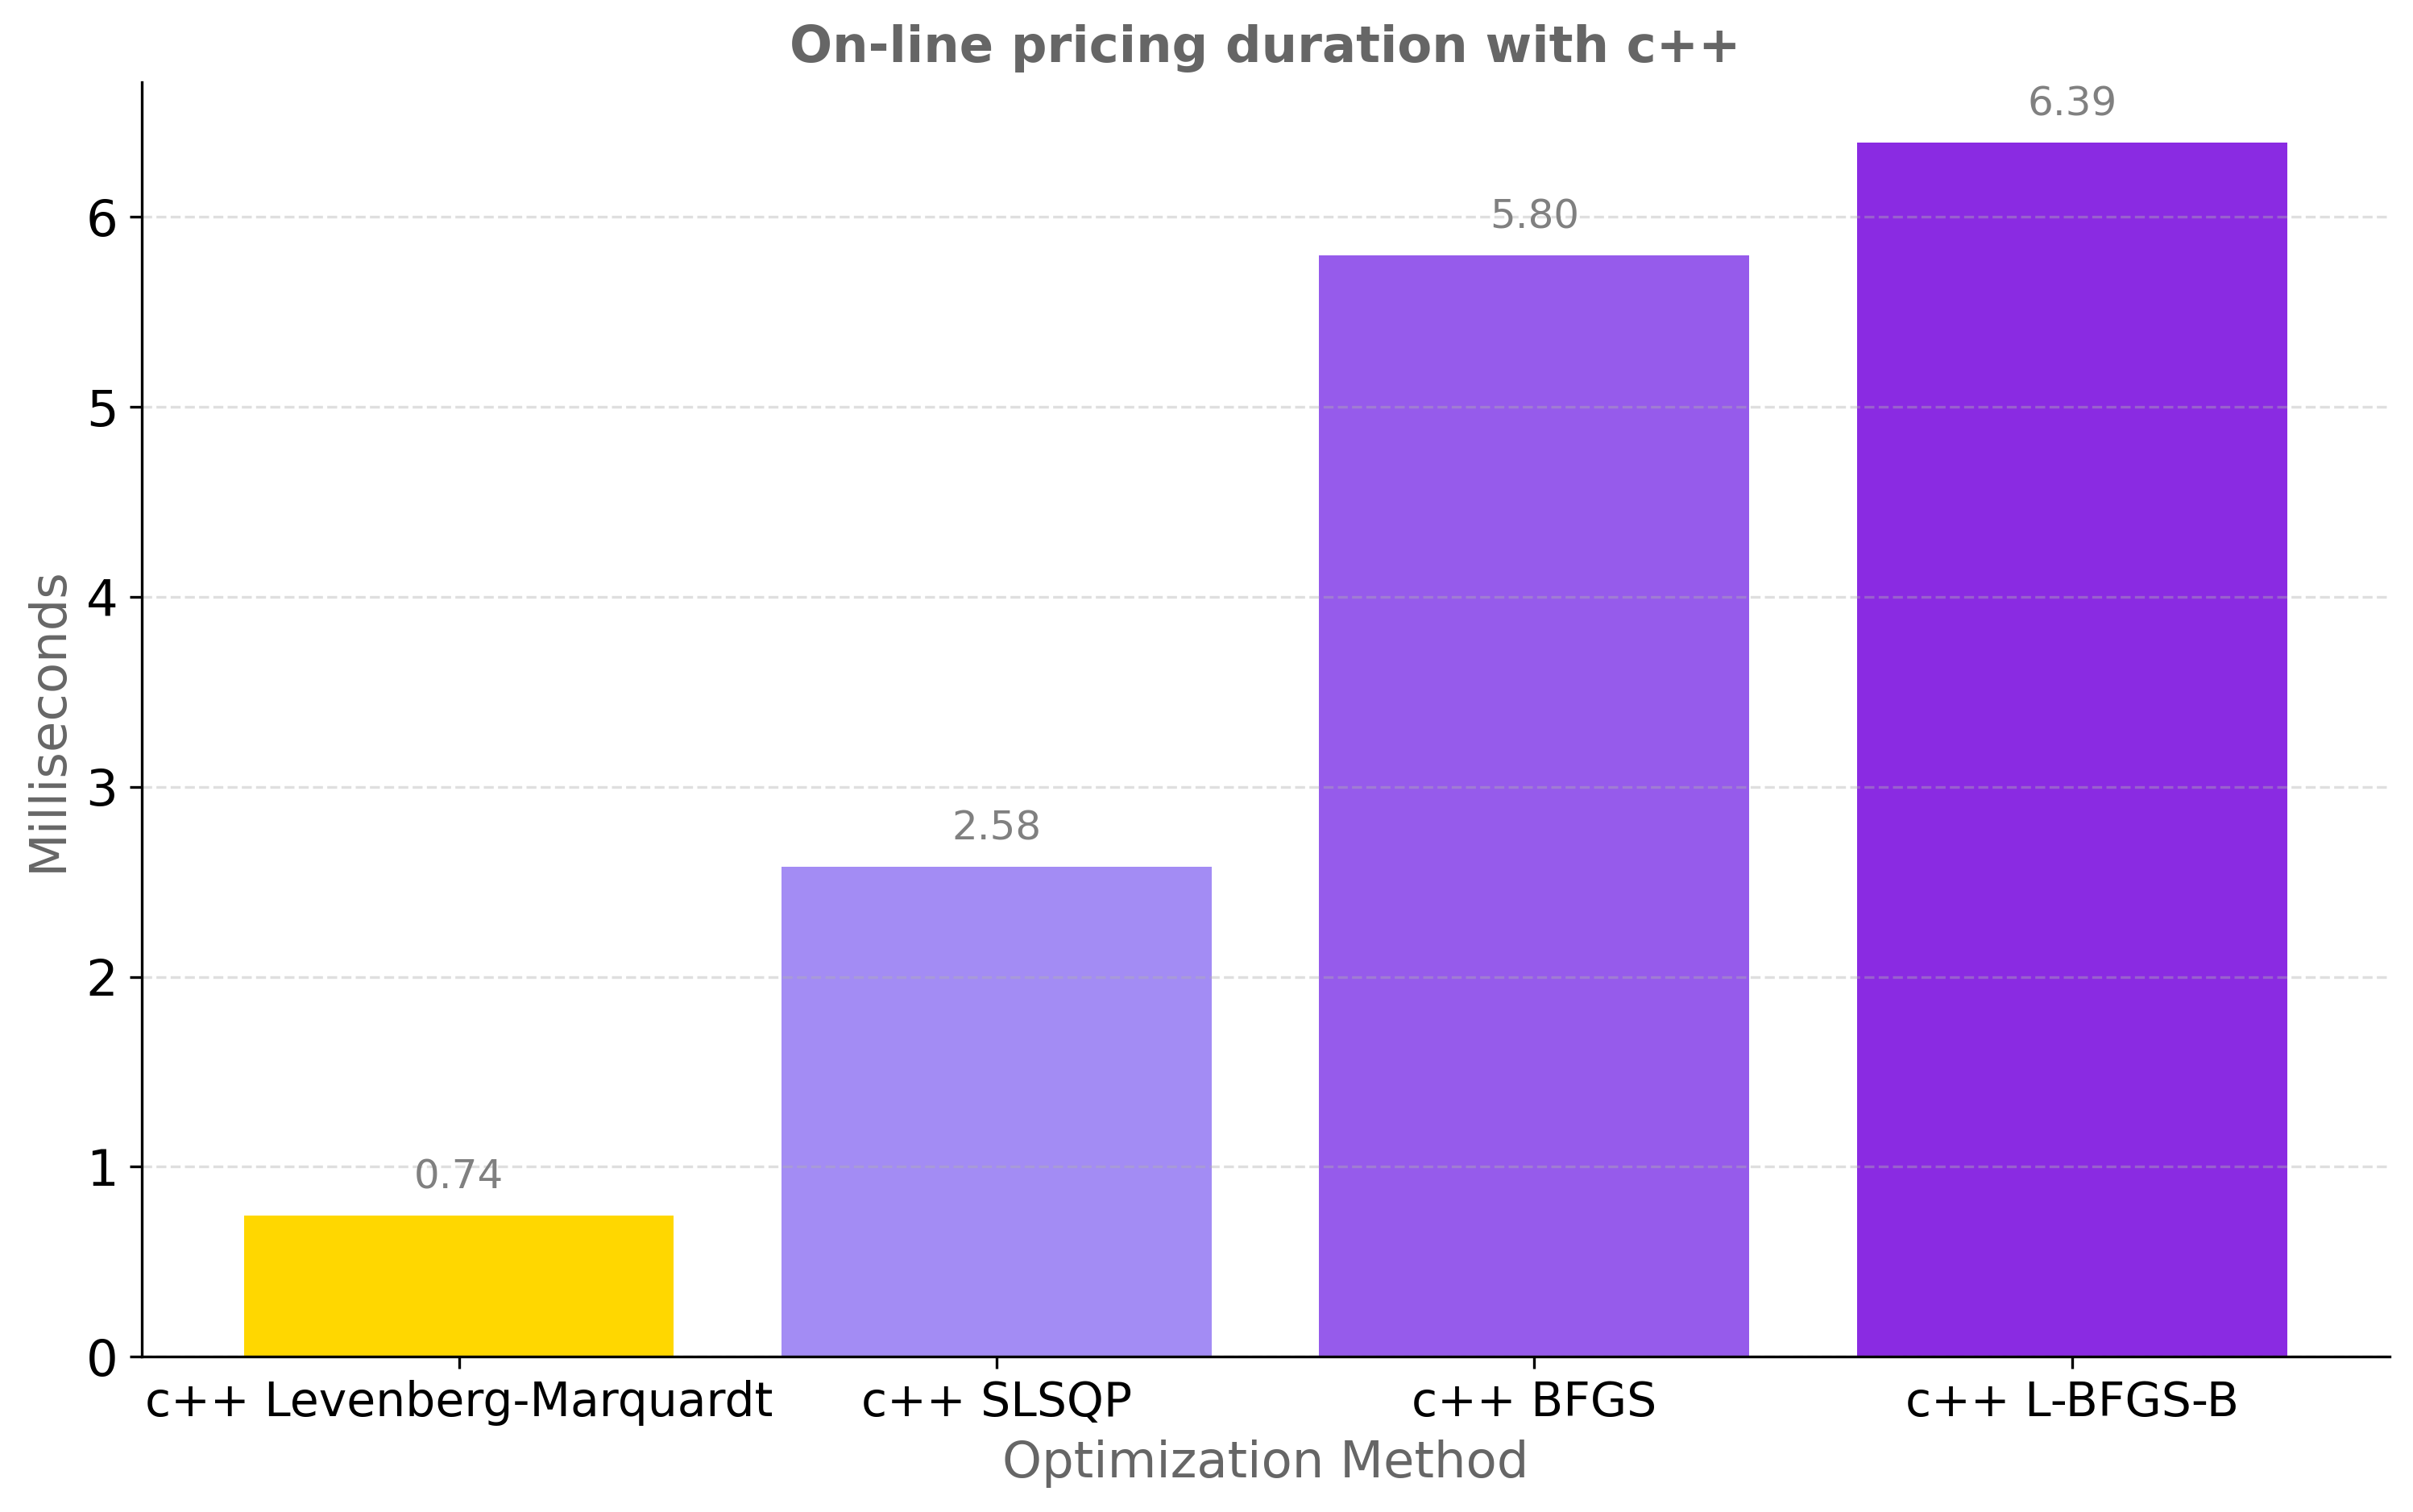

In [11]:
#Ploting the average calibration time

import matplotlib.pyplot as plt
import numpy as np

methods = ["c++ L-BFGS-B", "c++ SLSQP", "c++ BFGS", "c++ Levenberg-Marquardt"]
average_timing = np.mean(Timing, axis=0) * 1000  

methods[0], methods[-1] = methods[-1], methods[0]
average_timing[0], average_timing[-1] = average_timing[-1], average_timing[0]

plt.figure(figsize=(12, 6), dpi = 300)
colors = ['#FFD700', '#A38CF4', '#965BEB', '#8A2BE2']  

bars = plt.bar(methods, average_timing, color=colors)

plt.title("On-line pricing duration with c++", fontsize=15, alpha=0.6, fontweight='bold')
plt.ylabel("Milliseconds", fontsize=15, alpha=0.6)
plt.xlabel("Optimization Method",  fontsize=15, alpha=0.6)

plt.subplots_adjust(bottom=0.001)
plt.xticks(fontsize=14)
plt.yticks(fontsize=15)

for bar, value in zip(bars, average_timing):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{value:.2f}',
             ha='center', va='bottom', fontsize=12, color='gray')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()


## - Learning the Rough Bergomi model in a time lapse


1614
[ 0.0874266   0.113923    0.0813577   0.119689    0.157552    0.0695512
  0.146975    0.0661179   2.85968    -0.00353918  0.138854  ]


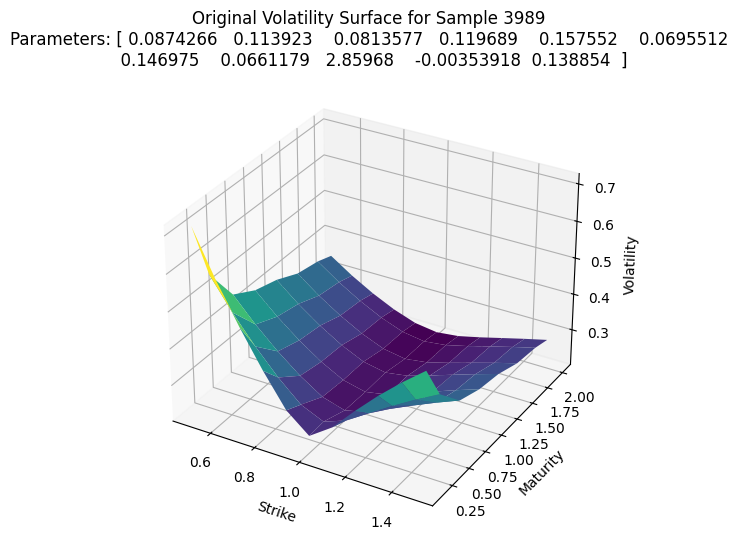

1/1 [==============================] - 0s 9ms/step


In [12]:
from keras.callbacks import ModelCheckpoint
import os
from datetime import datetime
import numpy as np

current_dir = os.getcwd()

now =  datetime.now().strftime('%Y%m%d%H%M%S')

folder_path = os.path.join(current_dir, now)
os.makedirs(folder_path, exist_ok=True)

strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

X, Y = np.meshgrid(strikes, maturities)


sample_ind = 3989
X_sample = x_test_transform[sample_ind]
y_sample = y_test_transform[sample_ind]

original = myinverse(X_sample)


original_index = indices_test[sample_ind]
vol_data_orig = yy[original_index]
vol_matrix_orig = vol_data_orig.reshape(len(maturities), len(strikes))

print(original_index)
print(xx[original_index])

min_volatility = np.min(vol_matrix_orig)
max_volatility = np.max(vol_matrix_orig)


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, vol_matrix_orig, cmap='viridis')
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
ax.set_title(f'Original Volatility Surface for Sample {sample_ind}\nParameters: {original}')
plt.savefig(os.path.join(folder_path, 'surface_volatility.png'))

plt.show()
Epochs = 301

epochs_to_plot = [1, 100, 200,300,  400 ,500]
for i in range(1, Epochs):
    
    modelGEN.load_weights('models1/model_{0}.h5'.format(i))
    
    # Calculate the prediction for this epoch
    a = modelGEN.predict(X_sample.reshape(1,11))[0]
    b = scale.inverse_transform(a.reshape(1, -1))


    # Convert the predictions to a volatility surface
    volatility_surface = np.reshape(b, X.shape)

    # Display the volatility surface
    fig = plt.figure(figsize=(8,6) , dpi=600)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, volatility_surface, cmap='viridis')
    
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Volatility')
    ax.set_zlim(min_volatility, max_volatility)
    plt.title('Epoch {0}'.format(i))
    
    ax.set_zlim(min_volatility, max_volatility)

    # Save the plot
    plt.savefig(os.path.join(folder_path, 'epoch_{0}.png'.format(i)))
    plt.close(fig)  

## Checking the Error of the Neural Net

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import pickle
from datetime import datetime

S0 = 1.
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])
strikes_dim = len(strikes)
maturities_dim = len(maturities)

##### AVERAGE VALUES #######
X_sample = x_test_transform
y_sample = y_test
Epochs = 300

# Calculate color scale based on the last epoch
last_epoch = Epochs + 1
modelGEN.load_weights(f'models1/model_{last_epoch}.h5')

# Prediction for the last epoch
last_epoch_predictions = xinversetransform(modelGEN.predict(X_sample))
last_epoch_reshaped_prediction = np.reshape(last_epoch_predictions, (20000, 88))

# Calculate errors
# Calculate errors for the last epoch
last_epoch_errors = [
    np.mean(100 * np.abs((y_sample - last_epoch_reshaped_prediction) / y_sample), axis=0),
    100 * np.std(np.abs((y_sample - last_epoch_reshaped_prediction) / y_sample), axis=0),
    100 * np.max(np.abs((y_sample - last_epoch_reshaped_prediction) / y_sample), axis=0)
]

color_scale_formatters = [
    mtick.PercentFormatter(),
    mtick.PercentFormatter(),
    mtick.PercentFormatter()
]

predictions_directory = 'predictions'
if not os.path.exists(predictions_directory):
    os.makedirs(predictions_directory)

for idx, formatter in enumerate(color_scale_formatters):
    color_scale_filename = f"{predictions_directory}/color_scale_formatter_{idx}.pkl"
    with open(color_scale_filename, 'wb') as file:
        pickle.dump(formatter, file)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
predictions_folder = f"{predictions_directory}_{timestamp}"
os.makedirs(predictions_folder, exist_ok=True)

for folder in ["models1", predictions_folder, f"{predictions_folder}/plots/average_error",
               f"{predictions_folder}/plots/std_error", f"{predictions_folder}/plots/max_error"]:
    if not os.path.exists(folder):
        os.makedirs(folder)

for epoch in range(10, Epochs + 1, 10):
    modelGEN.load_weights(f'models1/model_{epoch}.h5')

    
    predictions = xinversetransform(modelGEN.predict(X_sample))
    reshaped_prediction = np.reshape(predictions, (20000, 88))

    # Calculate errors for the current epoch
    current_epoch_errors = [
        np.mean(100 * np.abs((y_sample - reshaped_prediction) / y_sample), axis=0),
        100 * np.std(np.abs((y_sample - reshaped_prediction) / y_sample), axis=0),
        100 * np.max(np.abs((y_sample - reshaped_prediction) / y_sample), axis=0)
    ]

    # Save the current epoch errors
    current_epoch_errors_filename = f"{predictions_folder}/current_epoch_errors_{epoch}.pkl"
    with open(current_epoch_errors_filename, 'wb') as file:
        pickle.dump(current_epoch_errors, file)

    titles = ["Average relative error", "Std relative error", "Maximum relative error"]
    folder_names = ["average_error", "std_error", "max_error"]

    for idx, (title, folder) in enumerate(zip(titles, folder_names)):
        plt.figure(figsize=(14, 4))
        plt.title(f"{title} Epoch {epoch}", fontsize=15, y=1.04)
        plt.imshow(current_epoch_errors[idx].reshape(maturities_dim, strikes_dim), cmap='viridis')

        # Use the color scale from the last epoch_errors
        formatter = mtick.FuncFormatter(lambda x, _: f"{x:.2f}%")
        plt.colorbar(format=formatter)

        ax = plt.gca()  
        ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
        ax.set_xticklabels(strikes)
        ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
        ax.set_yticklabels(maturities)
        plt.xlabel("Strike", fontsize=15, labelpad=5)
        plt.ylabel("Maturity", fontsize=15, labelpad=5)
        plt.tight_layout()

        # Color Limit
        plt.clim(last_epoch_errors[idx].min(), last_epoch_errors[idx].max())

        if not os.path.exists(f"{predictions_folder}/plots/{folder}"):
            os.makedirs(f"{predictions_folder}/plots/{folder}")

        plt.savefig(f"{predictions_folder}/plots/{folder}/plot_{epoch}.png", dpi=600, bbox_inches='tight')
        plt.close()

    print(f"Epoch: {epoch}, Shape of prediction: {np.array(predictions).shape}")


# Simulating a live situation <a name="taking-a-sample-outside-the-train-test"></a>
## - taking a sample outside the train test
## - doing the entire process and checking the error

[-1.83708780e-07 -4.81197146e-07  3.55730376e-07 -3.29779310e-07
 -3.52331694e-07  2.51416322e-07 -1.84492649e-07  2.39231811e-07
  9.05856585e-08  3.55360153e-07  4.44876853e-07]
0.0008204132658532043


Text(0.5, 0.92, 'Deep Learned volatility surface RMSE: 0.0008')

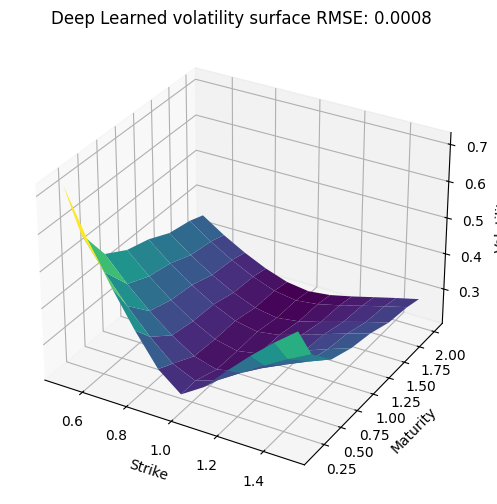

In [ ]:

#-Taking a sample outside the train-test                                              
#-Doing the entirer process and checking the Error



import numpy as np

strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

X, Y = np.meshgrid(strikes, maturities)
CalibratedParameters = []
Timing = []
solutions = np.zeros([4, 11])
times = np.zeros(4)
init = np.zeros(11)

i =   3989

I = scipy.optimize.least_squares(
    CostFuncLS2, 
    init, 
    args=( i, NNParameters), 
    jac=JacobianLS2,  
    gtol=1E-10,
)

def calculate_rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


finding_opt_para = I.x
opt_para = myinverse(finding_opt_para)
b = [0.08739, 0.114396,0.081359,0.11936,0.16022,0.068904,0.157369,0.069188,2.869056,-0.002141,0.145939 ] 
print(opt_para - b )


pricing = myscale(opt_para) 
pricing = np.array(pricing)

pricing = cppNeuralNet.NeuralNetwork(pricing.reshape(-1, 1), NNParameters)
pricing =xinversetransform([pricing])


volatility_surface = np.reshape(pricing, X.shape)

# Display the volatility surface
fig = plt.figure(figsize=(8,6) )
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, volatility_surface, cmap='viridis')

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')

pricing
yy[1614]
root_mean_squared_error = calculate_rmse(pricing, yy[1614])
print(root_mean_squared_error )

plt.title(f'Deep Learned volatility surface RMSE: {root_mean_squared_error:.4f}'.format(i))


# The C++ code Vs Tensorflow

In [ ]:


import numpy as np
import csv
import matplotlib.ticker as mtick
import cppNeuralNet as cppNeuralNet


cppNeuralNet = cppNeuralNet.NeuralNetworkFunctions()

S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)

X_sample = x_test_transform
y_sample = y_test


# C++
start_time = time.time()
prediction2 = [xinversetransform(cppNeuralNet.NeuralNetwork(X_sample[i], NNParameters).reshape(1, -1))  for i in range(len(y_sample)) ]
prediction2 = np.reshape(prediction2, (20000, 88))


# Tensorflow
start_time = time.time()
prediction3 = xinversetransform(modelGEN.predict(X_sample))
prediction3 = np.reshape(prediction3, (20000, 88))


#C++ - Tensorflow

diff3 = np.mean(np.abs(np.array(prediction2) - np.array(prediction3)))

print(diff3)